# Computer Topography Image Compliance Analysis 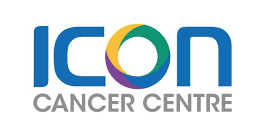
## David Jolly, Senior Medical Physicist
### Icon Cancer Centre

## One Minute Introduction to Radiation Therapy

Radiation therapy is the treatment of cancer using high doses or radiation (most commonly photons). Treatment is typically delivered using linear accelerators that rotate around the patient, targeting the tumour and avoiding healthy tissue. Generally speaking, around 50% of all cancer patients will receive some form of radiation therapy as part of their treatment and around half of those will be cured by the treatment. 


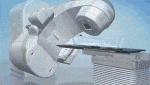


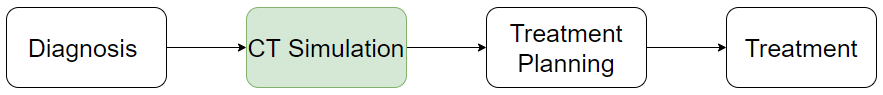


Simulation produces CT images that are stored in DICOM (Digital Imaging and Communications in Medicine) format. We run a script on all patient DICOMs and scrape then store information. This is the data I will be analysing and showing today.


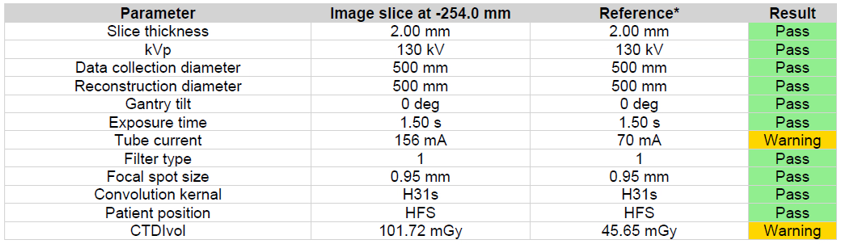

### Hypothesis

Bulk analysis of historical CT parameters can be used to set appropriate tolerances for future patient scans 

#### To formally frame the problem

* The main problem that needs to be solved is to find appropriate scan parameters (tube current and CTDIvol) dependent on the anatomical region.

* The normality of these distributions will be tested to determine if standard statistical values (mean, stdev) can be used to appropriately model tolerances. If not, then it is likely that more sophisticated predictive models such as Machine Learning will need to be considered.

* Other variables of interest will also be visualised, including the distribution of scans across manufacturer, model and institution 

### Abridged Data Dictionary

There are 39 columns of data within this set, the below dictionary is abridged to display only information pertinent to this study.

| Field | Description
| :--- | :---
| **PatientID** | Anonymised unique patient identifier - Primary Key
| **StudyDate** | Date that image was taken, format is DD/MM/YYYY hh:mm:ss
| **Manufacturer** | Vendor whom produced imaging system (CT or MR)
| **Model** | Model of imaging system
| **Institution** | Location where scanner is located
| **Modality** | CT or MR, only interested in CT data for this work, so MR will be filtered out
| **BodyRegion** | Anatomical region of scanned patient, IMPORTANT DATA
| **srt** | Stands for 'stereotactic radiation therapy'. 0 = non-stereo and 1 = stereo. Scan parameters may differ between techniques and thus data may need to be filtered and analysed independently. 
| **SliceThickness** | Physical distance between image slices (mm)
| **kVP** | Kilovoltage peak is the peak potential (V) applied to the CT X-ray tube
| **ReconstructionDiameter** | Diameter of reconstructed image (mm)
| **ExposureTime** | Total time of radiation exposure (ms)
| **TubeCurrent** | Current applied to kV tube (mA), a higher number represents more X-rays and thus a 'stronger' beam
| **FilterType** | Type of filtration used on X-ray beam
| **FocalSpotSize** | Focal spot size on X-ray target (mm), smaller values give better resolution
| **ConvolutionKernal** | Algorithm used to reconstruct images from raw data
| **PatientPosition** | Orientation of patient when scanned. HFS = head first supine, FFS = feet first supine, HFP = head first prone, HFDL = head first-decubitus left, HFDR = head first-decubitus reft, FFDL = feet first-decubitus left, FFDR = feet first-decubitus left. FFP = feet first prone
| **CTDIvol** | CT dose index (mGy), measure of patient x-ray dose. Want to minimise value without compromising image quality.

In [1]:
#Importing Libraries

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import scipy.stats as sc
import statsmodels.graphics.gofplots as sm

In [2]:
#Importing Raw csv data
def import_ctic():
    return pd.read_csv('../input/ic-data/Image_Compliance_DATA.csv')

ctic = import_ctic()

## Data Cleaning

Dropping all non-CT data (MR and PT)

In [3]:
ctic.drop(ctic[ctic['Modality'] == 'MR'].index, inplace = True)

In [4]:
ctic.drop(ctic[ctic['Modality'] == 'PT'].index, inplace = True)

Filling in several columns that contain NaN

In [5]:
ctic.fillna({'FilterType': 'Filter Unknown', 'Institution':'Institution Unknown'}, inplace=True)

Converting 'StudyDate' to DateTime format

In [6]:
ctic['StudyDate'] = pd.to_datetime(ctic['StudyDate'])

Dropping rows without a specified BodyRegion

In [7]:
ctic.drop(ctic[ctic['BodyRegion'] == '(body region unspecified)'].index, inplace = True)

Removing all data from one scanner as it is an outlier and skews the data

In [8]:
ctic.drop(ctic[(ctic.Institution == 'QXR St Andrews')].index, inplace = True)

### Presenting cleaned data columns of interest

In [9]:
ctic_clean = ctic[['StudyDate',
                    'Manufacturer',
                    'Model',
                    'Institution',
                    'BodyRegion',
                    'TubeCurrent',
                    'PatientPosition',
                    'CTDIvol',
                    'ConvolutionKernal',
                    'kVP',
                    'srt']]
ctic_clean.head(5)

,StudyDate,Manufacturer,Model,Institution,BodyRegion,TubeCurrent,PatientPosition,CTDIvol,ConvolutionKernal,kVP,srt
1,2021-04-14,GE MEDICAL SYSTEMS,Optima CT660,Windsor Gardens Oncology,Pelvis,411,HFS,0.000000,STANDARD,120,0
3,2021-04-15,SIEMENS,SOMATOM Confidence,ICON Midland,Chest,155,HFS,8.019834,Bf37f,120,0
4,2021-04-19,TOSHIBA,Aquilion ONE,QXR GCPH,Head,300,HFS,79.600000,FC26,120,1
5,2021-04-20,TOSHIBA,Aquilion ONE,QXR GCPH,Chest,150,HFS,10.300000,FC13,120,0
6,2021-04-20,SIEMENS,SOMATOM Confidence,ICON Midland,Chest,515,HFS,26.646544,Bf37f,120,0


Creating new DataFrames for each BodyType

In [10]:
pelvis = ctic_clean[ctic_clean.BodyRegion == 'Pelvis']
chest = ctic_clean[ctic_clean.BodyRegion == 'Chest']
head = ctic_clean[ctic_clean.BodyRegion == 'Head']
abdomen = ctic_clean[ctic_clean.BodyRegion == 'Abdomen']
spine = ctic_clean[ctic_clean.BodyRegion == 'Spine']
extremity = ctic_clean[ctic_clean.BodyRegion == 'Extremity']

Creating a new DataFrame that removes all rows with a CTDIvol value of 0 (some CT scanners do not report this value)

In [11]:
drop_ctdi0 = ctic_clean.drop(ctic_clean[(ctic_clean.CTDIvol == 0)].index)

Creating new DataFrames for each BodyType, with CTDIvol values

In [12]:
pelvis_ctdi0 = drop_ctdi0[drop_ctdi0.BodyRegion == 'Pelvis']
chest_ctdi0 = drop_ctdi0[drop_ctdi0.BodyRegion == 'Chest']
head_ctdi0 = drop_ctdi0[drop_ctdi0.BodyRegion == 'Head']
abdomen_ctdi0 = drop_ctdi0[drop_ctdi0.BodyRegion == 'Abdomen']
spine_ctdi0 = drop_ctdi0[drop_ctdi0.BodyRegion == 'Spine']
extremity_ctdi0 = drop_ctdi0[drop_ctdi0.BodyRegion == 'Extremity']

In [13]:
SM = ['SIEMENS','Siemens Healthineers']
SIEMENS = ctic_clean[ctic_clean['Manufacturer'].isin(SM)]

TOSHIBA = ctic_clean[ctic_clean.Manufacturer == 'TOSHIBA']
GE = ctic_clean[ctic_clean.Manufacturer == 'GE MEDICAL SYSTEMS']
Canon = ctic_clean[ctic_clean.Manufacturer == 'Canon Medical Systems']

## Data Analysis

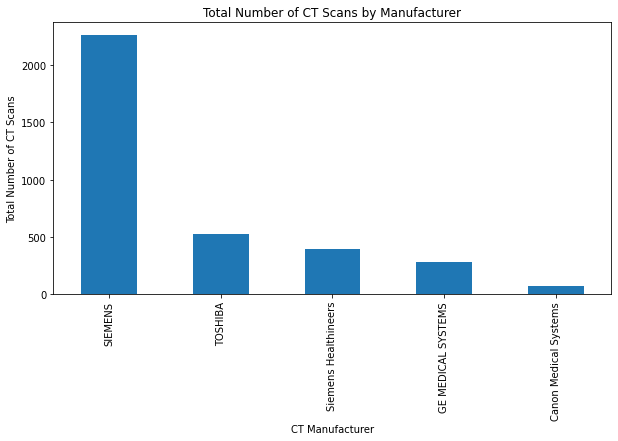

In [14]:
ctic_clean['Manufacturer'].value_counts().plot(kind='bar',figsize=(10,5))
plt.ylabel('Total Number of CT Scans')
plt.xlabel('CT Manufacturer')
plt.title('Total Number of CT Scans by Manufacturer');

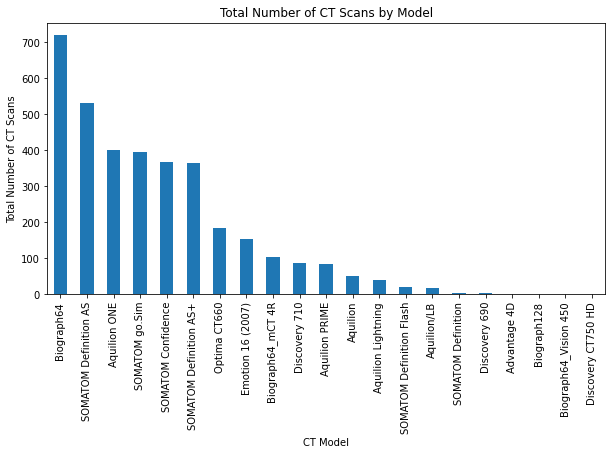

In [15]:
ctic_clean['Model'].value_counts().plot(kind='bar',figsize=(10,5))
plt.ylabel('Total Number of CT Scans')
plt.xlabel('CT Model')
plt.title('Total Number of CT Scans by Model');

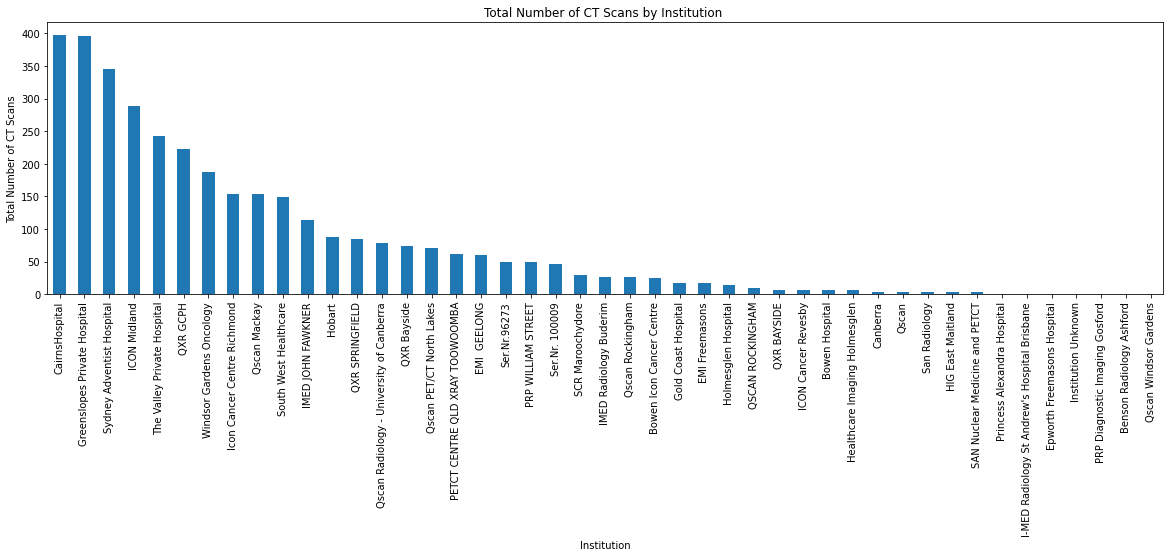

In [16]:
ctic_clean['Institution'].value_counts().plot(kind='bar', figsize=(20,5))
plt.ylabel('Total Number of CT Scans')
plt.xlabel('Institution')
plt.title('Total Number of CT Scans by Institution ');

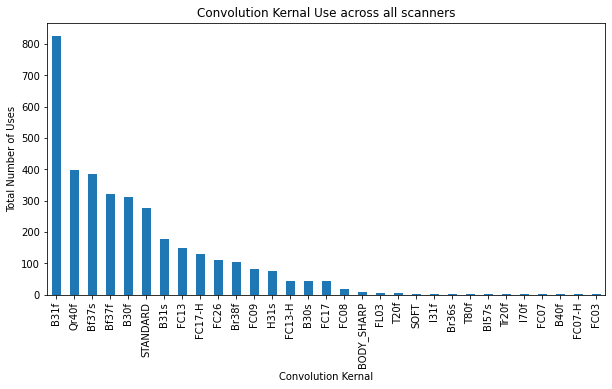

In [17]:
ctic_clean['ConvolutionKernal'].value_counts().plot(kind='bar',figsize=(10,5))
plt.ylabel('Total Number of Uses')
plt.xlabel('Convolution Kernal')
plt.title('Convolution Kernal Use across all scanners');

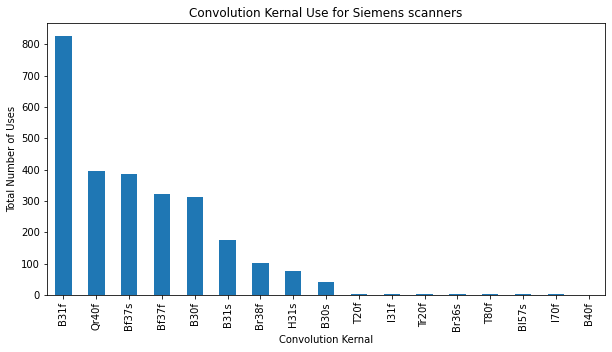

In [18]:
SIEMENS['ConvolutionKernal'].value_counts().plot(kind='bar',figsize=(10,5))
plt.ylabel('Total Number of Uses')
plt.xlabel('Convolution Kernal')
plt.title('Convolution Kernal Use for Siemens scanners');

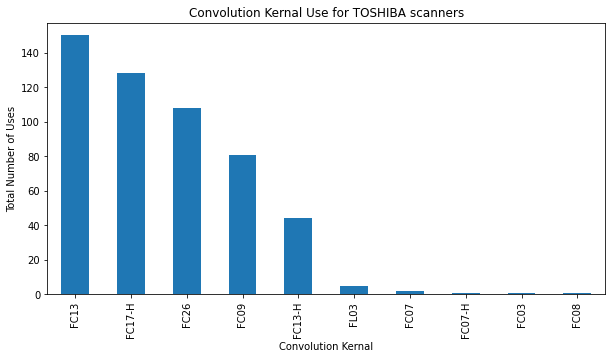

In [19]:
TOSHIBA['ConvolutionKernal'].value_counts().plot(kind='bar',figsize=(10,5))
plt.ylabel('Total Number of Uses')
plt.xlabel('Convolution Kernal')
plt.title('Convolution Kernal Use for TOSHIBA scanners');

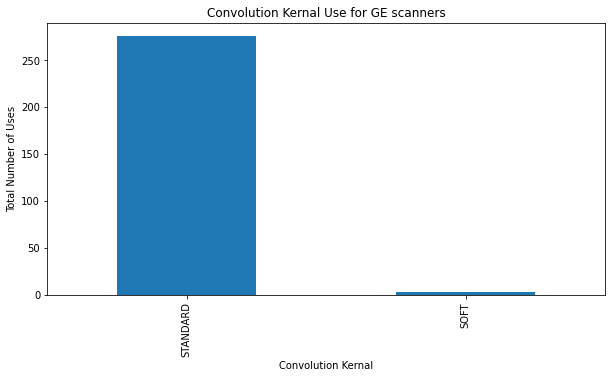

In [20]:
GE['ConvolutionKernal'].value_counts().plot(kind='bar',figsize=(10,5))
plt.ylabel('Total Number of Uses')
plt.xlabel('Convolution Kernal')
plt.title('Convolution Kernal Use for GE scanners');

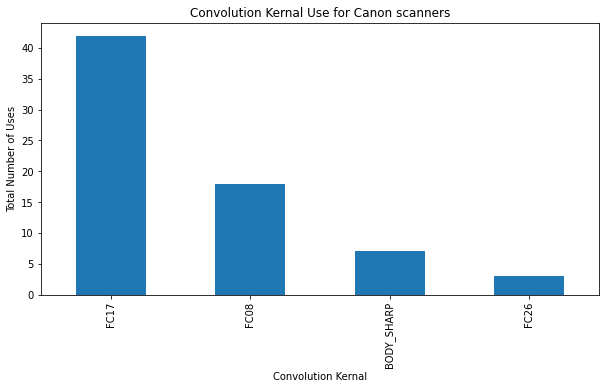

In [21]:
Canon['ConvolutionKernal'].value_counts().plot(kind='bar',figsize=(10,5))
plt.ylabel('Total Number of Uses')
plt.xlabel('Convolution Kernal')
plt.title('Convolution Kernal Use for Canon scanners');

In [22]:
rcParams['figure.figsize'] = 15,8

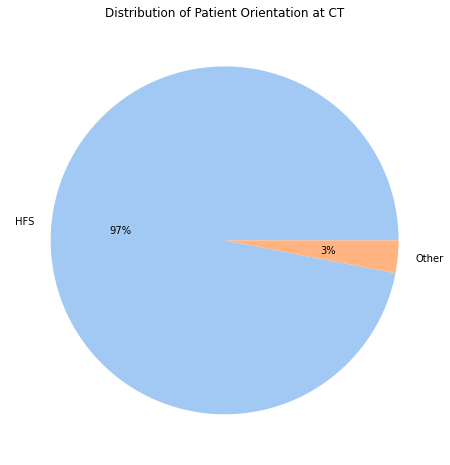

In [23]:
labels = ['HFS', 'Other',]
data = [3719, 116]
colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%');

plt.title('Distribution of Patient Orientation at CT');

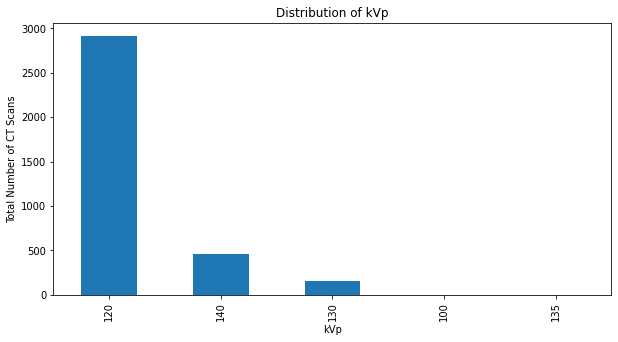

In [24]:
ctic_clean['kVP'].value_counts().plot(kind='bar',figsize=(10,5))
plt.ylabel('Total Number of CT Scans')
plt.xlabel('kVp')
plt.title('Distribution of kVp');

In [25]:
ctic_clean['kVP'].describe().round(1)

count    3527.0
mean      123.0
std         6.9
min       100.0
25%       120.0
50%       120.0
75%       120.0
max       140.0
Name: kVP, dtype: float64

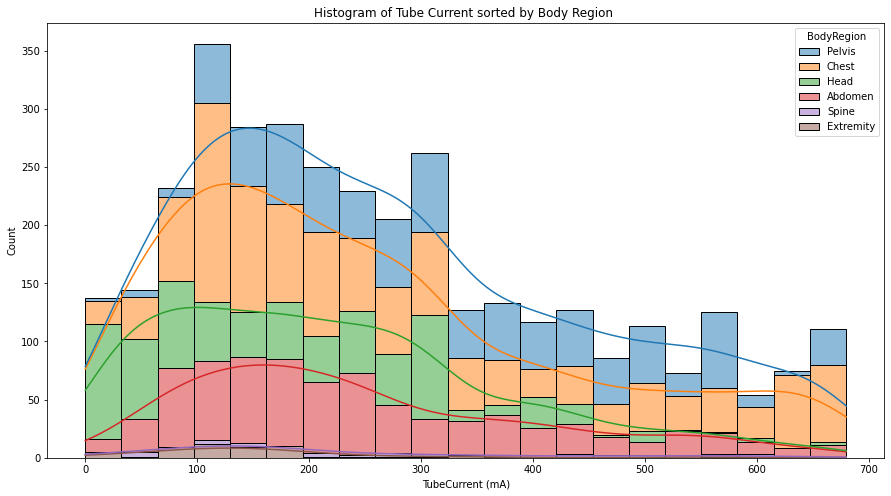

In [26]:
sns.histplot(data=ctic_clean, x='TubeCurrent', kde=True, hue='BodyRegion', multiple='stack');
plt.ylabel('Count')
plt.xlabel('TubeCurrent (mA)')
plt.title('Histogram of Tube Current sorted by Body Region ');

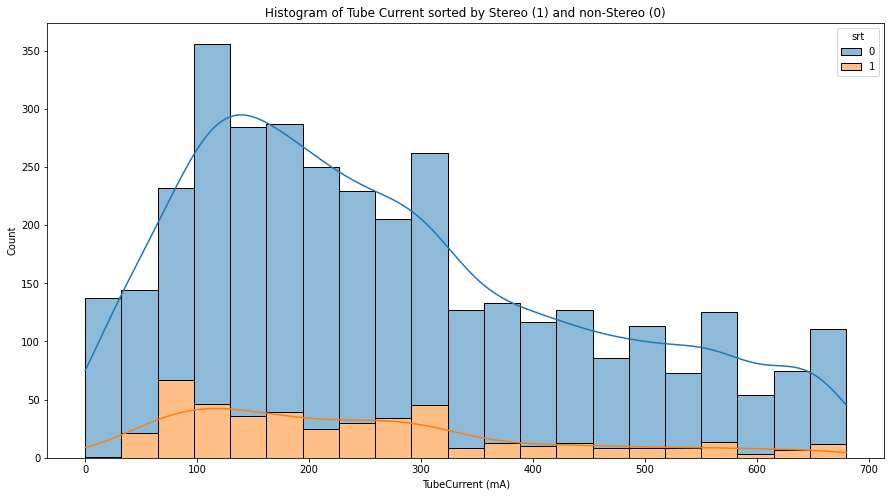

In [27]:
sns.histplot(data=ctic_clean, x='TubeCurrent', kde=True, hue='srt', multiple='stack');
plt.ylabel('Count')
plt.xlabel('TubeCurrent (mA)')
plt.title('Histogram of Tube Current sorted by Stereo (1) and non-Stereo (0)');

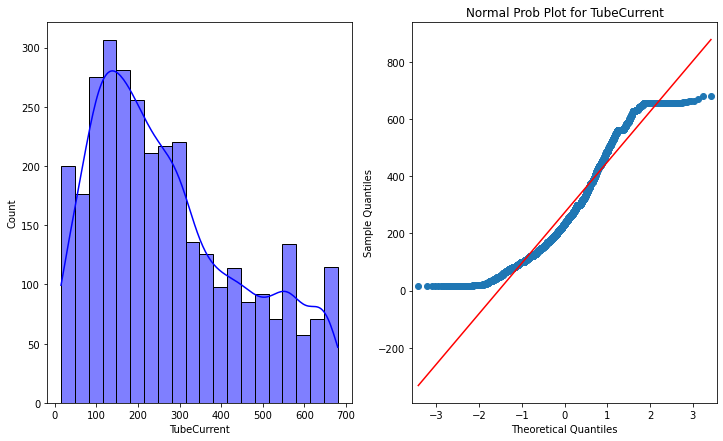

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
sns.histplot(drop_ctdi0.TubeCurrent, kde=True, color ='blue', ax=ax[0])

sm.ProbPlot(drop_ctdi0.TubeCurrent).qqplot(line='s', ax=ax[1]);
plt.title('Normal Prob Plot for TubeCurrent');

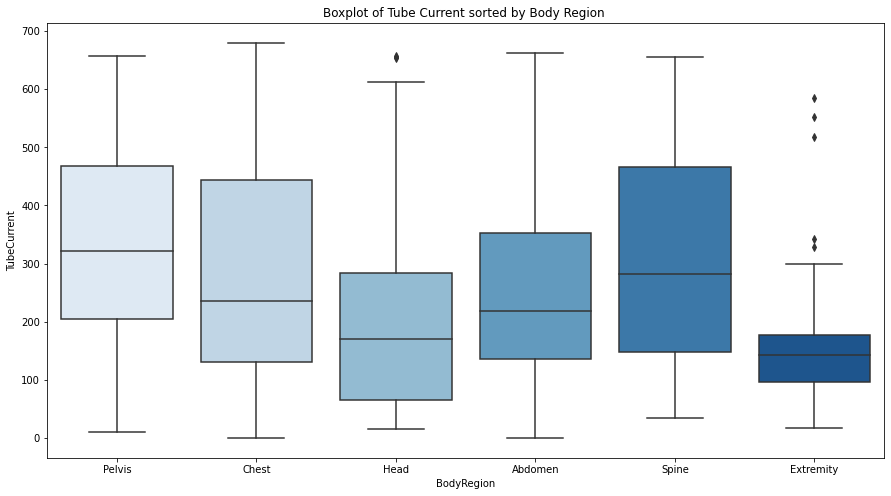

In [29]:
sns.boxplot( y=ctic_clean["TubeCurrent"], x=ctic_clean["BodyRegion"],palette='Blues');
plt.title('Boxplot of Tube Current sorted by Body Region ');

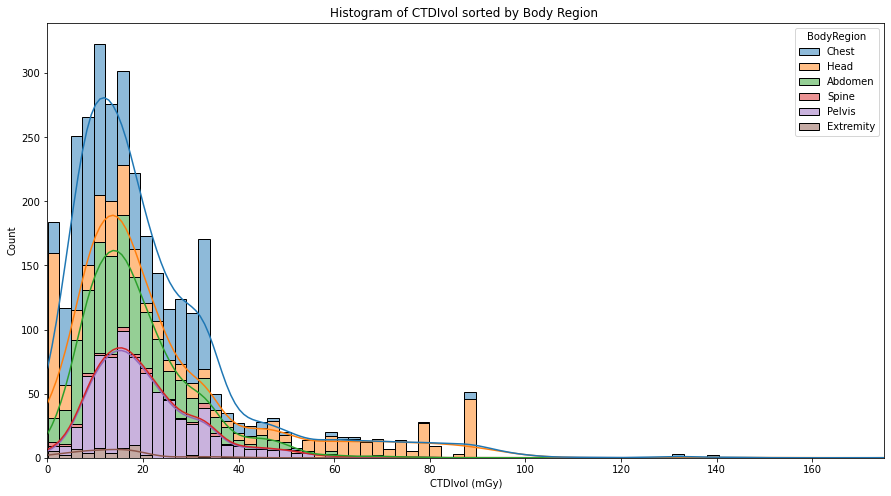

In [30]:
sns.histplot(data=drop_ctdi0, x='CTDIvol', kde=True, hue='BodyRegion', multiple='stack')
plt.xlim([0, 175])
plt.ylabel('Count')
plt.xlabel('CTDIvol (mGy)')
plt.title('Histogram of CTDIvol sorted by Body Region ');

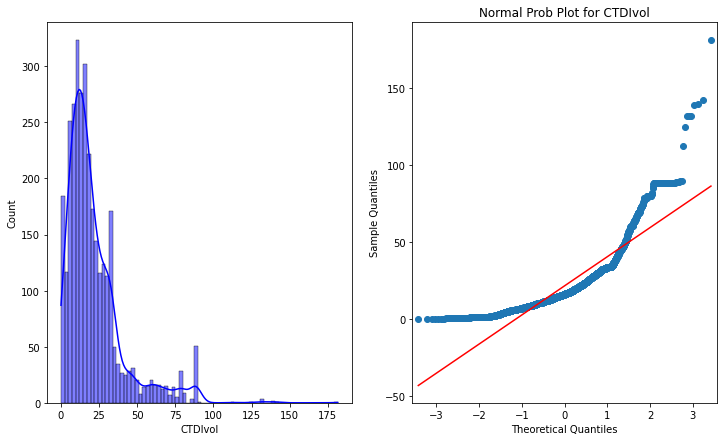

In [31]:
fig1, ax = plt.subplots(1, 2, figsize=(12, 7))
sns.histplot(drop_ctdi0.CTDIvol, kde=True, color ='blue', ax=ax[0])

sm.ProbPlot(drop_ctdi0.CTDIvol).qqplot(line='s', ax=ax[1]);
plt.title('Normal Prob Plot for CTDIvol');

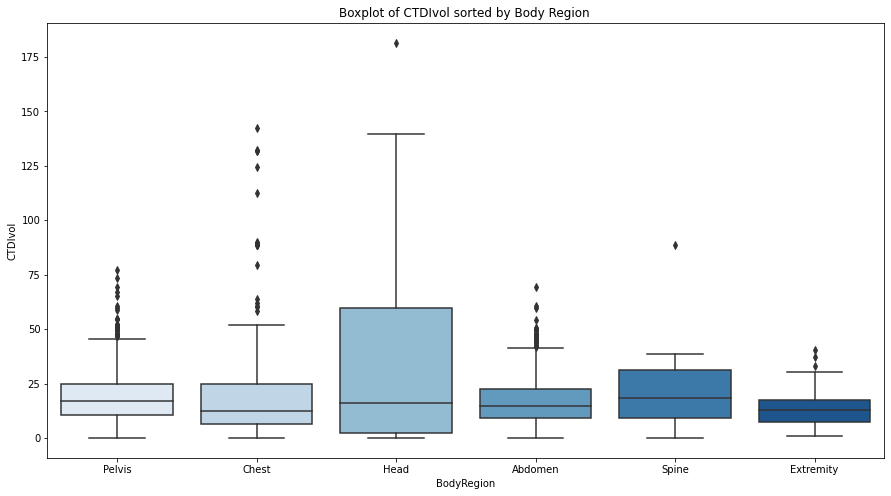

In [32]:
sns.boxplot( y=ctic_clean["CTDIvol"], x=ctic_clean["BodyRegion"],palette='Blues');
plt.title('Boxplot of CTDIvol sorted by Body Region ');

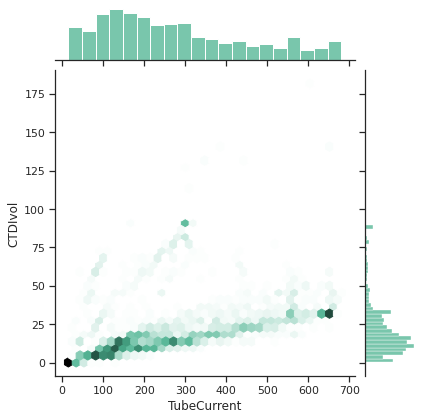

In [33]:
sns.set_theme(style="ticks")
sns.jointplot(data=drop_ctdi0, x='TubeCurrent', y='CTDIvol', kind="hex", color="#4CB391");

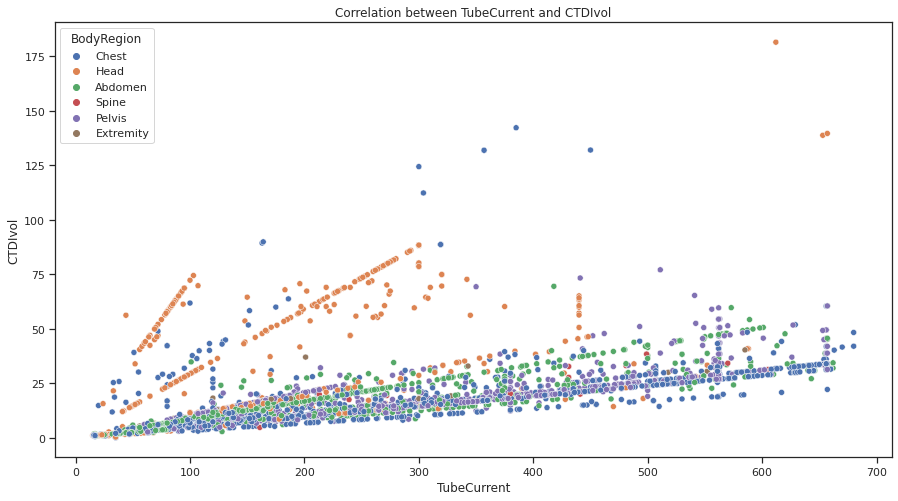

In [34]:
sns.scatterplot(data=drop_ctdi0,x="TubeCurrent", y="CTDIvol", hue="BodyRegion");
plt.title('Correlation between TubeCurrent and CTDIvol');

## Example Tolerance Calculation (assuming a normal distribution)

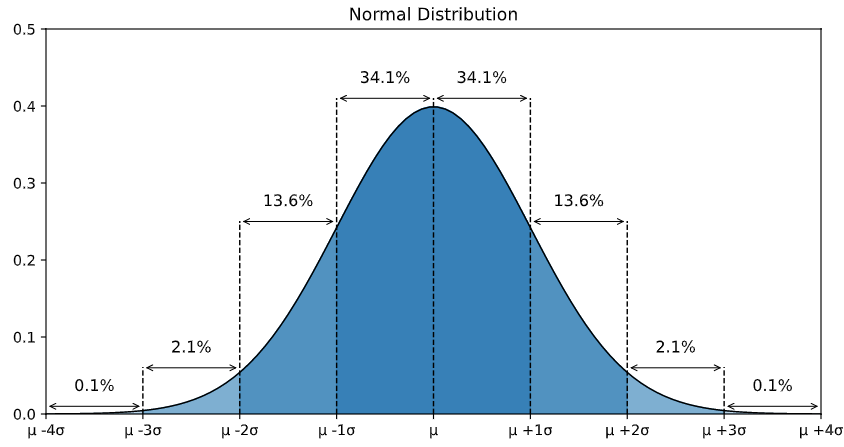


In [35]:
stats = drop_ctdi0[['TubeCurrent','CTDIvol' ]].describe().round(1)
stats

,TubeCurrent,CTDIvol
count,3241.0,3241.0
mean,272.6,21.6
std,176.5,18.9
min,15.0,0.1
25%,130.0,9.6
50%,234.0,16.2
75%,388.0,27.7
max,680.0,181.5


In [36]:
num_stats_TubeCurrent = pd.to_numeric(stats.TubeCurrent)

print(f'For all anatomical regions the upper bound tolerance for TubeCurrent is \033[1m{num_stats_TubeCurrent.to_numpy()[1] + 2*(num_stats_TubeCurrent.to_numpy()[2])}\033[0m mA')


For all anatomical regions the upper bound tolerance for TubeCurrent is 625.6 mA


# Conclusion

The above method can be used to calculate a tolerance for each anatomical site and scanner. This would give a better indication than the current method (using a single reference scan) but is still unsatisfactory due to the fact the data is not a normal distribution. 

To get more useful predictions, sophisticated modelling tools such as Machine Learning (using scikit-learn) will need to be employed.